In [1]:
import torch
import torch.nn as nn
import os
# Arrange GPU devices starting from 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 0"  # Set the GPUs 2 and 3 to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'ppl_sm_d52_w128_b4_e50'
model = torch.load(os.path.join('models', model_name,f"{model_name}.pth"))
# model = _model.to(device)
# model = nn.DataParallel(model).to(device)
model.eval()

DataParallel(
  (module): UNETPP(
    (up_op): Upsample(scale_factor=(1.0, 2.0, 2.0), mode='trilinear')
    (stem): double_conv(
      (dconv): Sequential(
        (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): GroupNorm(1, 16, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): GroupNorm(1, 16, eps=1e-05, affine=True)
        (5): ReLU(inplace=True)
      )
    )
    (encoder): ModuleList(
      (0): down_op(
        (down): Sequential(
          (0): MaxPool3d(kernel_size=3, stride=(1, 2, 2), padding=1, dilation=1, ceil_mode=False)
          (1): double_conv(
            (dconv): Sequential(
              (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (1): GroupNorm(1, 32, eps=1e-05, affine=True)
              (2): ReLU(inplace=True)
              (3): Conv3d(32, 32, kernel_size=(3, 3, 3), 

In [2]:
from utils import get_dataloader
from dataset import BratsDataset

test_dataloader = get_dataloader(dataset=BratsDataset, phase="test", img_depth=155, img_width=240, data_type=[
      "-t1n.nii.gz",
      "-t1c.nii.gz",
      # "-t2w.nii.gz",
      "-t2f.nii.gz"
    ], batch_size=1)


In [3]:
from utils import dice_coef_metric_per_classes, jaccard_coef_metric_per_classes
from skimage.transform import resize as sk_resize
import numpy as np
from tqdm import tqdm
def compute_scores_per_classes(model,          # nodel which is UNeT3D 
                               dataloader,     # tuple consisting of ( id , image tensor , mask tensor )
                               classes):       # classes : WT , TC , ET 
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            pred = torch.sigmoid(logits).detach().cpu().numpy()
            threshold = 0.33
            pred = (pred >= threshold).astype(int)
            # pred = np.array([sk_resize(_pred, (3, 155, 240, 240), preserve_range=True)
            #                 for _pred in pred])
            targets = targets.detach().cpu().numpy()
            
            # Now finding the overlap between the raw prediction i.e. logit & the mask i.e. target & finding the dice & iou scores 
            dice_scores = dice_coef_metric_per_classes(pred, targets)
            iou_scores = jaccard_coef_metric_per_classes(pred, targets)

            # storing both dice & iou scores in the list declared 
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes 

In [4]:
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, test_dataloader, ['WT', 'TC', 'ET']
    )

100%|██████████| 125/125 [02:13<00:00,  1.07s/it]


In [5]:
import pandas as pd
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
# CONCAT BOTH THE COLUMNS ALONG AXIS 1 & SORT THE TWO 
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
103,0.685901,0.521956,0.604096,0.432763,0.534959,0.365149
115,0.885109,0.793898,0.390871,0.242908,0.270892,0.156665
122,0.959732,0.922581,0.354271,0.215267,0.232854,0.131768
57,0.926076,0.862329,0.580208,0.408657,0.321953,0.191862
56,0.830117,0.709572,0.334690,0.200978,0.248074,0.141601


In [6]:
[i for i in val_metics_df.std()]

[0.10141537514915178,
 0.13337035754790919,
 0.22450094659674388,
 0.19615547655677795,
 0.19008940853739284,
 0.14144849321342406]

In [7]:
val_metics_df.mean()

WT dice       0.870251
WT jaccard    0.781998
TC dice       0.475165
TC jaccard    0.339961
ET dice       0.322392
ET jaccard    0.207937
dtype: float64

In [8]:
val_metics_df.to_excel(f'inference_res/(re)method_2_{model_name}.xlsx')

/tmp/ipykernel_1813100/2895340528.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax)
/tmp/ipykernel_1813100/2895340528.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)


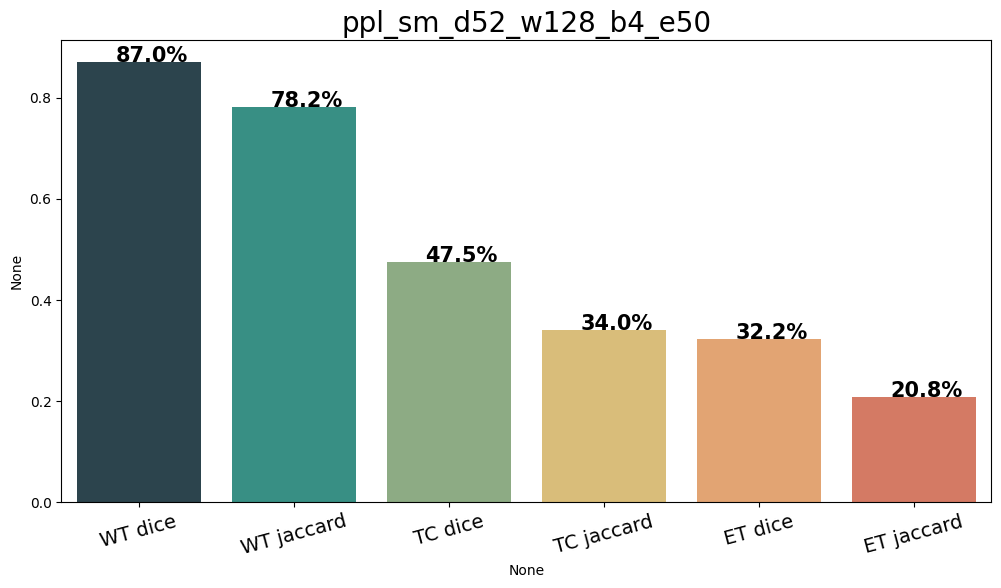

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['#264653', '#2a9d8f', '#8ab17d', '#e9c46a', '#f4a261', '#e76f51']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax)
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)
ax.set_title(f"{model_name}", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig(f"inference_res/(re){model_name}.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
# fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')